# pandasAI 智能查询演示

展示如何在智慧会议系统中使用 pandasAI 进行智能数据查询

本笔记本演示了 pandasAI 与智慧会议系统的集成，包括：
- 生成演示数据
- 智能查询示例
- 自定义查询功能
- 响应处理和可视化

## 导入依赖库

In [1]:
!pip install -r pandasai/requirements.txt

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import sys
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandasai import Agent
import pandasai as pai
from faker import Faker
import random
import os
from datetime import datetime, timedelta
from pandasai.core.response.chart import ChartResponse
from matplotlib.figure import Figure as MatplotlibFigure
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), "pandasai"))

from llm import setup_pandasai_llm, create_pandasai_agent

# 初始化 Faker
fake = Faker("zh_CN")

print("✅ 所有依赖库导入成功")

✅ 所有依赖库导入成功


## 响应处理函数

定义处理 pandasAI 响应的函数，支持多种响应类型的渲染

In [10]:
def render_pandasai_response(response, query: str = "") -> bool:
    """处理和显示 pandasAI 的响应"""
    try:
        print(f"📊 响应类型: {type(response).__name__}")
        
        if isinstance(response, ChartResponse):
            print("🔍 识别为 ChartResponse")
            chart_value = response.value
            
            if isinstance(chart_value, go.Figure):
                chart_value.show()
            elif isinstance(chart_value, MatplotlibFigure):
                plt.show()
            elif isinstance(chart_value, str) and chart_value.endswith(".png"):
                from IPython.display import Image, display
                display(Image(chart_value))
            else:
                print(f"⚠️ 无法识别的 ChartResponse 图表内容类型: {type(chart_value)}")
                print(chart_value)
            return True
            
        elif isinstance(response, go.Figure):
            response.show()
            return True
            
        elif isinstance(response, MatplotlibFigure):
            plt.show()
            return True
            
        elif isinstance(response, pd.DataFrame):
            display(response)
            return True
            
        elif isinstance(response, (str, int, float)):
            print(f"📝 结果: {response}")
            return True
            
        elif isinstance(response, list):
            for i, item in enumerate(response):
                print(f"项目 {i + 1}: {item}")
            return True
            
        elif isinstance(response, dict):
            if "data" in response and "layout" in response:
                fig = go.Figure(data=response["data"], layout=response["layout"])
                fig.show()
            else:
                print(response)
            return True
            
        elif hasattr(response, "__dict__"):
            print(response.__dict__)
            return True
            
        else:
            print("❓ 无法识别的响应类型")
            print(response)
            return False
            
    except Exception as e:
        print(f"❌ 处理 PandasAI 响应时出错: {e}")
        return False

print("✅ 响应处理函数定义完成")

✅ 响应处理函数定义完成


## 生成演示数据

创建会议室、会议记录和用户数据用于演示

In [11]:
def generate_demo_data():
    """生成演示数据"""
    # 会议室数据
    rooms_data = []
    room_types = ["会议室", "培训室", "视频会议室", "小型会议室"]
    floors = ["A", "B", "C"]
    
    for i in range(10):
        rooms_data.append({
            "room_id": i + 1,
            "room_name": f"{random.choice(floors)}{random.randint(101, 999)}{random.choice(room_types)}",
            "floor": random.choice(floors),
            "capacity": random.choice([4, 6, 8, 12, 20, 30]),
            "room_type": random.choice(room_types),
            "equipment": random.choice(["基础设备", "视频会议设备", "投影设备", "白板设备"]),
            "hourly_rate": random.randint(50, 200),
        })
    
    # 会议数据
    meetings_data = []
    topics = ["产品评审", "技术讨论", "项目规划", "客户会议", "团队建设", "培训会议"]
    departments = ["研发部", "测试部", "市场部", "产品部", "运营部"]
    
    for i in range(100):
        start_time = fake.date_time_between(start_date="-60d", end_date="+30d")
        duration = random.choice([30, 60, 90, 120, 180])
        end_time = start_time + timedelta(minutes=duration)
        
        meetings_data.append({
            "meeting_id": i + 1,
            "title": random.choice(topics),
            "room_id": random.randint(1, 10),
            "department": random.choice(departments),
            "start_time": start_time,
            "end_time": end_time,
            "duration_minutes": duration,
            "participants": random.randint(2, 20),
            "status": random.choice(["已预定", "进行中", "已完成", "已取消"]),
            "cost": random.randint(100, 1000),
        })
    
    # 用户数据
    users_data = []
    roles = ["会议组织者", "会议参与者", "系统管理员"]
    
    for i in range(30):
        users_data.append({
            "user_id": i + 1,
            "username": fake.user_name(),
            "name": fake.name(),
            "role": random.choice(roles),
            "department": random.choice(departments),
            "email": fake.email(),
            "join_date": fake.date_between(start_date="-365d", end_date="today"),
        })
    
    return (
        pd.DataFrame(rooms_data),
        pd.DataFrame(meetings_data),
        pd.DataFrame(users_data),
    )

# 生成演示数据
rooms_df, meetings_df, users_df = generate_demo_data()

print(f"📊 数据生成完成:")
print(f"   - 会议室数量: {len(rooms_df)}")
print(f"   - 会议记录数: {len(meetings_df)}")
print(f"   - 用户数量: {len(users_df)}")

📊 数据生成完成:
   - 会议室数量: 10
   - 会议记录数: 100
   - 用户数量: 30


## 查看演示数据

In [12]:
print("🏢 会议室数据样本:")
display(rooms_df.head())

print("\n📅 会议数据样本:")
display(meetings_df.head())

print("\n👥 用户数据样本:")
display(users_df.head())

🏢 会议室数据样本:


,room_id,room_name,floor,capacity,room_type,equipment,hourly_rate
0,1,C178小型会议室,A,12,培训室,投影设备,81
1,2,B329小型会议室,A,30,视频会议室,投影设备,79
2,3,B213视频会议室,B,8,视频会议室,基础设备,159
3,4,A205小型会议室,C,20,培训室,视频会议设备,142
4,5,A735视频会议室,B,30,小型会议室,投影设备,189



📅 会议数据样本:


,meeting_id,title,room_id,department,start_time,end_time,duration_minutes,participants,status,cost
0,1,培训会议,10,产品部,2025-06-13 12:48:39.143184,2025-06-13 13:48:39.143184,60,16,已取消,945
1,2,培训会议,2,产品部,2025-07-11 07:32:51.860569,2025-07-11 08:02:51.860569,30,11,已完成,420
2,3,技术讨论,7,研发部,2025-07-07 10:14:04.850891,2025-07-07 13:14:04.850891,180,9,已预定,762
3,4,项目规划,2,运营部,2025-08-11 22:36:41.987171,2025-08-12 00:06:41.987171,90,8,已取消,834
4,5,项目规划,4,运营部,2025-08-04 22:24:38.758826,2025-08-04 23:54:38.758826,90,18,已取消,380



👥 用户数据样本:


,user_id,username,name,role,department,email,join_date
0,1,jtao,梁倩,会议组织者,测试部,dgong@example.net,2025-03-09
1,2,junzhu,彭秀梅,会议组织者,产品部,mwei@example.net,2024-10-15
2,3,acai,金建军,会议参与者,市场部,yong70@example.com,2025-05-09
3,4,hxiong,王辉,会议参与者,运营部,tqiao@example.org,2024-08-07
4,5,kangli,蒋成,会议参与者,运营部,yan16@example.net,2025-02-09


## 初始化 pandasAI

In [13]:
# 合并数据用于查询
merged_df = meetings_df.merge(rooms_df, on="room_id", how="left")
print(f"📊 合并后数据形状: {merged_df.shape}")

# 初始化 LLM 和 Agent
llm = setup_pandasai_llm()
print("✅ LLM 初始化完成")

agent = create_pandasai_agent(merged_df, llm)
if agent:
    print("✅ pandasAI Agent 创建成功")
else:
    print("❌ 无法创建 pandasAI Agent")

📊 合并后数据形状: (100, 16)
✅ LLM 初始化完成
✅ pandasAI Agent 创建成功


## 智能查询示例

以下是一些预定义的查询示例，展示 pandasAI 的智能分析能力

In [14]:
# 定义查询示例
query_examples = [
    "哪个会议室使用频率最高？",
    "各部门的会议时长分布如何？",
    "平均每次会议的成本是多少？",
    "哪些用户最常组织会议？",
    "会议室使用率随时间的变化趋势",
    "按楼层统计会议室使用情况",
    "绘制会议时长分布直方图",
    "显示各部门会议数量的柱状图",
    "创建会议室容量与使用频率的散点图",
    "生成会议成本的时间序列图",
]

print("📋 可用的查询示例:")
for i, query in enumerate(query_examples, 1):
    print(f"   {i}. {query}")

📋 可用的查询示例:
   1. 哪个会议室使用频率最高？
   2. 各部门的会议时长分布如何？
   3. 平均每次会议的成本是多少？
   4. 哪些用户最常组织会议？
   5. 会议室使用率随时间的变化趋势
   6. 按楼层统计会议室使用情况
   7. 绘制会议时长分布直方图
   8. 显示各部门会议数量的柱状图
   9. 创建会议室容量与使用频率的散点图
   10. 生成会议成本的时间序列图


### 执行查询示例 1: 会议室使用频率

In [15]:
query = "哪个会议室使用频率最高？"
print(f"🔍 执行查询: {query}")

if agent:
    try:
        response = agent.chat(query)
        print("✅ 查询完成！")
        render_pandasai_response(response, query)
    except Exception as e:
        print(f"❌ 查询失败: {e}")
else:
    print("❌ Agent 未初始化")

🔍 执行查询: 哪个会议室使用频率最高？
2025-07-15 16:17:04 [INFO] Question: 哪个会议室使用频率最高？
2025-07-15 16:17:04 [INFO] Running PandasAI with openai LLM...
2025-07-15 16:17:04 [INFO] Prompt ID: 40ace9b3-7b38-403e-8ce4-943f2811366c
2025-07-15 16:17:04 [INFO] Generating new code...
2025-07-15 16:17:04 [INFO] Using Prompt: <tables>

<table dialect="duckdb" table_name="table_6f31fb4ca2a7bb64b3a8947a7a2162f5" columns="[{"name": "meeting_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "title", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "room_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "department", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "start_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "end_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "duration_m

### 执行查询示例 2: 部门会议时长分布

In [16]:
query = "各部门的会议时长分布如何？"
print(f"🔍 执行查询: {query}")

if agent:
    try:
        response = agent.chat(query)
        print("✅ 查询完成！")
        render_pandasai_response(response, query)
    except Exception as e:
        print(f"❌ 查询失败: {e}")
else:
    print("❌ Agent 未初始化")

🔍 执行查询: 各部门的会议时长分布如何？
2025-07-15 16:17:31 [INFO] Question: 各部门的会议时长分布如何？
2025-07-15 16:17:31 [INFO] Running PandasAI with openai LLM...
2025-07-15 16:17:31 [INFO] Prompt ID: 83e089d7-b5ac-4253-ad1c-6d6505c5824a
2025-07-15 16:17:31 [INFO] Generating new code...
2025-07-15 16:17:31 [INFO] Using Prompt: <tables>

<table dialect="duckdb" table_name="table_6f31fb4ca2a7bb64b3a8947a7a2162f5" columns="[{"name": "meeting_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "title", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "room_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "department", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "start_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "end_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "duration

### 执行查询示例 3: 平均会议成本

In [17]:
query = "平均每次会议的成本是多少？"
print(f"🔍 执行查询: {query}")

if agent:
    try:
        response = agent.chat(query)
        print("✅ 查询完成！")
        render_pandasai_response(response, query)
    except Exception as e:
        print(f"❌ 查询失败: {e}")
else:
    print("❌ Agent 未初始化")

🔍 执行查询: 平均每次会议的成本是多少？
2025-07-15 16:18:00 [INFO] Question: 平均每次会议的成本是多少？
2025-07-15 16:18:00 [INFO] Running PandasAI with openai LLM...
2025-07-15 16:18:00 [INFO] Prompt ID: 1e3ed812-57dc-4c9f-8378-9062d5b57e5a
2025-07-15 16:18:00 [INFO] Generating new code...
2025-07-15 16:18:00 [INFO] Using Prompt: <tables>

<table dialect="duckdb" table_name="table_6f31fb4ca2a7bb64b3a8947a7a2162f5" columns="[{"name": "meeting_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "title", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "room_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "department", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "start_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "end_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "duration

### 执行查询示例 4: 会议时长分布图

🔍 执行查询: 绘制会议时长分布直方图
2025-07-15 16:36:54 [INFO] Question: 绘制会议时长分布直方图
2025-07-15 16:36:54 [INFO] Running PandasAI with openai LLM...
2025-07-15 16:36:54 [INFO] Prompt ID: bc4d3022-5657-4b49-a776-2e1e3ae0427f
2025-07-15 16:36:54 [INFO] Generating new code...
2025-07-15 16:36:54 [INFO] Using Prompt: <tables>

<table dialect="duckdb" table_name="table_6f31fb4ca2a7bb64b3a8947a7a2162f5" columns="[{"name": "meeting_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "title", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "room_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "department", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "start_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "end_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "duration_min

<string>:15: UserWarning: Glyph 20250 (\N{CJK UNIFIED IDEOGRAPH-4F1A}) missing from current font.
<string>:15: UserWarning: Glyph 35758 (\N{CJK UNIFIED IDEOGRAPH-8BAE}) missing from current font.
<string>:15: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
<string>:15: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
<string>:15: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
<string>:15: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
<string>:15: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
<string>:15: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
<string>:15: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from current font.
<string>:15: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
<string>:15: UserWar

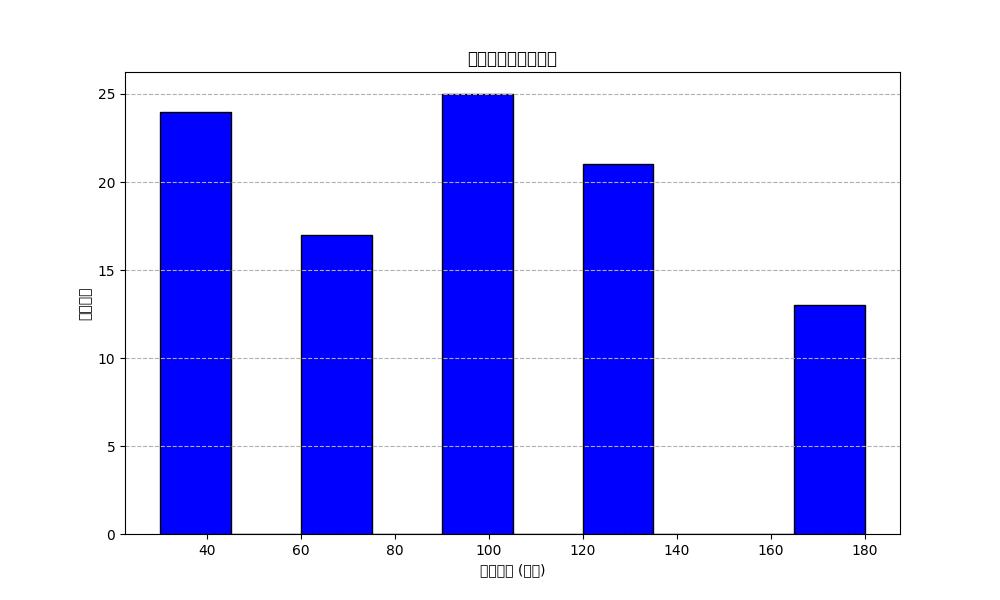

In [18]:
query = "绘制会议时长分布直方图"
print(f"🔍 执行查询: {query}")

if agent:
    try:
        response = agent.chat(query)
        print("✅ 查询完成！")
        render_pandasai_response(response, query)
    except Exception as e:
        print(f"❌ 查询失败: {e}")
else:
    print("❌ Agent 未初始化")

### 执行查询示例 5: 部门会议数量柱状图

🔍 执行查询: 显示各部门会议数量的柱状图
2025-07-15 16:37:09 [INFO] Question: 显示各部门会议数量的柱状图
2025-07-15 16:37:09 [INFO] Running PandasAI with openai LLM...
2025-07-15 16:37:10 [INFO] Prompt ID: c458d189-a927-485d-8e36-91a919fc2651
2025-07-15 16:37:10 [INFO] Generating new code...
2025-07-15 16:37:10 [INFO] Using Prompt: <tables>

<table dialect="duckdb" table_name="table_6f31fb4ca2a7bb64b3a8947a7a2162f5" columns="[{"name": "meeting_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "title", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "room_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "department", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "start_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "end_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "duration

<string>:17: UserWarning: Glyph 20135 (\N{CJK UNIFIED IDEOGRAPH-4EA7}) missing from current font.
<string>:17: UserWarning: Glyph 21697 (\N{CJK UNIFIED IDEOGRAPH-54C1}) missing from current font.
<string>:17: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from current font.
<string>:17: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from current font.
<string>:17: UserWarning: Glyph 22330 (\N{CJK UNIFIED IDEOGRAPH-573A}) missing from current font.
<string>:17: UserWarning: Glyph 30740 (\N{CJK UNIFIED IDEOGRAPH-7814}) missing from current font.
<string>:17: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from current font.
<string>:17: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
<string>:17: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
<string>:17: UserWarning: Glyph 36816 (\N{CJK UNIFIED IDEOGRAPH-8FD0}) missing from current font.
<string>:17: UserWar

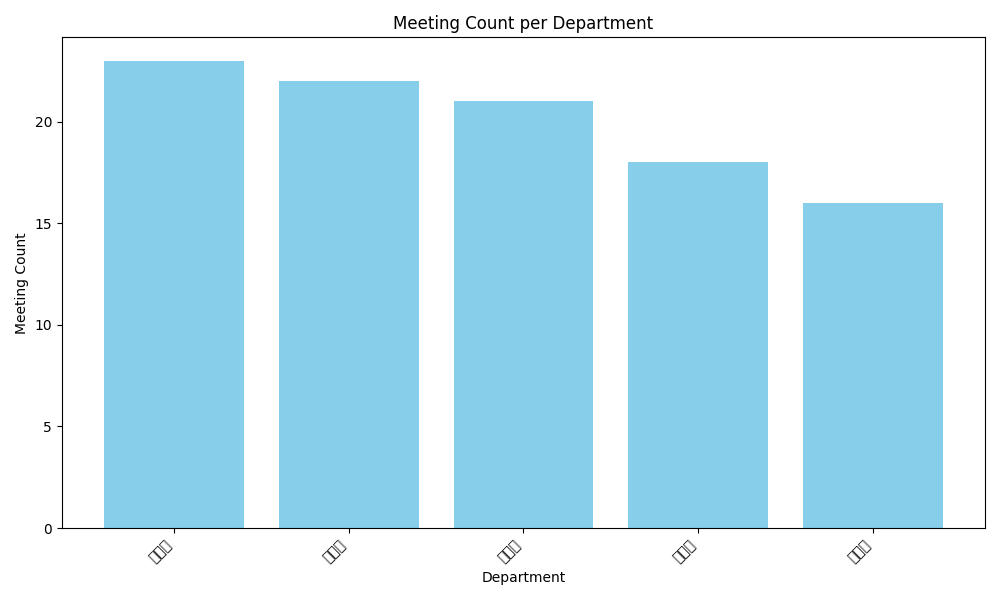

In [19]:
query = "显示各部门会议数量的柱状图"
print(f"🔍 执行查询: {query}")

if agent:
    try:
        response = agent.chat(query)
        print("✅ 查询完成！")
        render_pandasai_response(response, query)
    except Exception as e:
        print(f"❌ 查询失败: {e}")
else:
    print("❌ Agent 未初始化")

## 自定义查询区域

在这里您可以输入自己的查询并执行

In [20]:
# 自定义查询 - 修改这里的查询内容
custom_query = "按楼层统计会议室使用情况"

print(f"🔍 执行自定义查询: {custom_query}")

if agent and custom_query.strip():
    try:
        response = agent.chat(custom_query)
        print("✅ 查询完成！")
        render_pandasai_response(response, custom_query)
    except Exception as e:
        print(f"❌ 查询失败: {e}")
else:
    print("❌ Agent 未初始化或查询为空")

🔍 执行自定义查询: 按楼层统计会议室使用情况
2025-07-15 16:37:27 [INFO] Question: 按楼层统计会议室使用情况
2025-07-15 16:37:27 [INFO] Running PandasAI with openai LLM...
2025-07-15 16:37:27 [INFO] Prompt ID: 6820bd4a-e4d3-4c20-ae71-fbbeeed086aa
2025-07-15 16:37:27 [INFO] Generating new code...
2025-07-15 16:37:27 [INFO] Using Prompt: <tables>

<table dialect="duckdb" table_name="table_6f31fb4ca2a7bb64b3a8947a7a2162f5" columns="[{"name": "meeting_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "title", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "room_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "department", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "start_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "end_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "duratio

## 批量查询测试

执行多个查询来测试系统的稳定性

In [21]:
# 选择几个查询进行批量测试
batch_queries = [
    "会议室总数是多少？",
    "最受欢迎的会议主题是什么？",
    "哪个部门开会最多？",
]

print("🚀 开始批量查询测试")
print("=" * 50)

for i, query in enumerate(batch_queries, 1):
    print(f"\n📋 查询 {i}: {query}")
    print("-" * 30)
    
    if agent:
        try:
            response = agent.chat(query)
            print("✅ 查询成功")
            render_pandasai_response(response, query)
        except Exception as e:
            print(f"❌ 查询失败: {e}")
    else:
        print("❌ Agent 未初始化")

print("\n" + "=" * 50)
print("✅ 批量查询测试完成")

🚀 开始批量查询测试

📋 查询 1: 会议室总数是多少？
------------------------------
2025-07-15 16:37:42 [INFO] Question: 会议室总数是多少？
2025-07-15 16:37:42 [INFO] Running PandasAI with openai LLM...
2025-07-15 16:37:42 [INFO] Prompt ID: 9731189d-dc11-421b-9292-5702919a2331
2025-07-15 16:37:42 [INFO] Generating new code...
2025-07-15 16:37:42 [INFO] Using Prompt: <tables>

<table dialect="duckdb" table_name="table_6f31fb4ca2a7bb64b3a8947a7a2162f5" columns="[{"name": "meeting_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "title", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "room_id", "type": "integer", "description": null, "expression": null, "alias": null}, {"name": "department", "type": "string", "description": null, "expression": null, "alias": null}, {"name": "start_time", "type": "datetime", "description": null, "expression": null, "alias": null}, {"name": "end_time", "type": "datetime", "description": null, "expression": null,

## 数据统计概览

使用传统方法展示数据的基本统计信息，与 pandasAI 结果进行对比

In [22]:
print("📊 数据统计概览")
print("=" * 40)

# 基本统计
print(f"会议室总数: {len(rooms_df)}")
print(f"会议记录总数: {len(meetings_df)}")
print(f"用户总数: {len(users_df)}")

# 会议统计
print(f"\n📅 会议统计:")
print(f"平均会议时长: {meetings_df['duration_minutes'].mean():.1f} 分钟")
print(f"平均会议成本: {meetings_df['cost'].mean():.2f} 元")
print(f"平均参与人数: {meetings_df['participants'].mean():.1f} 人")

# 部门分布
print(f"\n🏢 部门会议分布:")
dept_counts = meetings_df['department'].value_counts()
for dept, count in dept_counts.items():
    print(f"  {dept}: {count} 次会议")

# 会议室使用频率
print(f"\n🏠 会议室使用频率:")
room_usage = meetings_df['room_id'].value_counts().head(5)
for room_id, count in room_usage.items():
    room_name = rooms_df[rooms_df['room_id'] == room_id]['room_name'].iloc[0]
    print(f"  {room_name}: {count} 次使用")

📊 数据统计概览
会议室总数: 10
会议记录总数: 100
用户总数: 30

📅 会议统计:
平均会议时长: 88.5 分钟
平均会议成本: 572.09 元
平均参与人数: 10.4 人

🏢 部门会议分布:
  产品部: 23 次会议
  市场部: 22 次会议
  研发部: 21 次会议
  测试部: 18 次会议
  运营部: 16 次会议

🏠 会议室使用频率:
  A205小型会议室: 14 次使用
  C178小型会议室: 13 次使用
  B213视频会议室: 12 次使用
  B230视频会议室: 11 次使用
  C583培训室: 10 次使用


## 使用说明

### 环境要求
1. 确保设置了 `DASHSCOPE_API_KEY` 环境变量
2. 安装所需的依赖包

### 使用方法
1. 运行上述所有单元格来初始化环境和数据
2. 在自定义查询区域修改 `custom_query` 变量来测试不同的查询
3. 查看智能分析结果和图表

### 支持的查询类型
- 数据统计查询
- 图表生成请求
- 趋势分析
- 数据筛选和排序
- 复杂的数据关联分析